# **Dataset Testing**

# **YOLOv5**
https://www.kaggle.com/andradaolteanu/greatbarrierreef-yolo-full-guide-train-infer

In [ ]:
import seaborn
import numpy as np 
import pandas as pd 
import cv2
import random
import yaml
import shutil
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html

In [ ]:
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print("Notebook Color Scheme : ")
seaborn.palplot(seaborn.color_palette(my_colors))

In [ ]:
# 創造兩個資料夾(image)(label)
import os, sys
files = ["images", "labels"]
for i in range(len(files)):
    if os.path.isdir(files[i]): print(f"{files[i]} 資料夾已創建!!")
    else: os.mkdir(files[i])

# 創 images 和 labels 的資料夾內的東西
%cd images
!mkdir train
!mkdir val
%cd /kaggle/working
%cd labels
!mkdir train
!mkdir val
%cd /kaggle/working
# 查看當前資料夾內容
!dir

# 1. **預處理train.csv**

https://www.kaggle.com/andradaolteanu/greatbarrierreef-full-guide-to-bboxaugmentation

In [ ]:
# Read training dataset and testing dataset
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
test_df = pd.read_csv("../input/tensorflow-great-barrier-reef/test.csv")

df1_styler = train_df.sample(n = 3, random_state = 24).style.set_table_attributes("style = 'display:inline'").set_caption('Sample Train Data')
display_html(df1_styler._repr_html_(), raw = True)

# **2. Train_images介紹**

In [ ]:
# Create a "path" column containing full path to the frames
base_folder = "../input/tensorflow-great-barrier-reef/train_images"

# Add data path labels
train_df["path"] = base_folder + "/video_" + \
                    train_df['video_id'].astype(str) + "/" +\
                    train_df['video_frame'].astype(str) +".jpg"

df1_styler = train_df.sample(n = 3, random_state = 24)
display_html(df1_styler._repr_html_(), raw = True)

In [ ]:
# Calculate the number of total annotations within the frame (no_annotations是看這張照片有多少個annotations)
# 加入no_annotations的labels
train_df["no_annotations"] = train_df["annotations"].apply(lambda x: len(eval(x)))

style = train_df.sample(n = 10, random_state = 24).style.set_table_attributes("style = 'display:inline'").set_caption('After add no_annotation Sample Train Data')
display_html(style._repr_html_(), raw = True)

In [ ]:
# Show training image
def show_image(path, annot, axs = None):
    '''
    Shows an image and marks any COTS annotated within the frame.
    path: full path to the .jpg image
    annot: string of the annotation for the coordinates of COTS
    '''
    
    # This is in case we plot only 1 image
    if (axs == None): fig, axs = plt.subplots(figsize = (25, 10))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"], 
                                     linewidth = 3, edgecolor = "#FF6103", facecolor = 'none')
            axs.add_patch(rect)
    axs.axis("off")

# 儲存那些annotations = 5的圖片path，放在一個list裡面，取第[n]個
path = list(train_df[train_df["no_annotations"] == 1]["path"])[0]  
print(f"Path : {path}")
# 儲存那些annotations = 5的圖片annotations，放在一個list裡面，取第[n]個
annot = list(train_df[train_df["no_annotations"] == 1]["annotations"])[0]
print(f"Annotations : {annot}")

show_image(path, annot)

# **3. Bounding Box Augmentation**

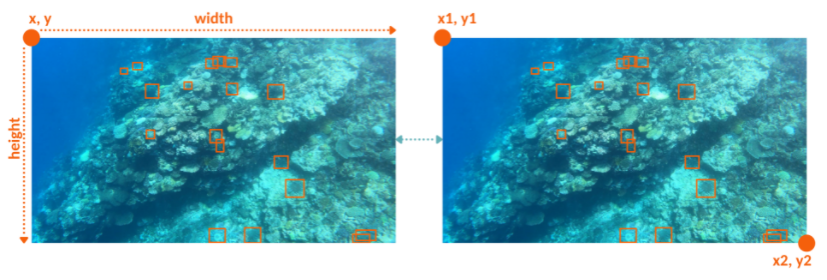

In [ ]:
def format_annotations(x):
    '''
    Changes annotations from format {x, y, width, height} to {x1, y1, x2, y2}.
    x: a string of the initial format.
    '''
    annotations = eval(x)
    new_annotations = []

    if annotations:
        for annot in annotations:
            new_annotations.append([annot["x"],
                                    annot["y"],
                                    annot["x"] + annot["width"],
                                    annot["y"] + annot["height"]
                                   ])
    
    if new_annotations: return str(new_annotations)
    else: return "[]"

# Create a new column with the new formated annotations
train_df["f_annotations"] = train_df["annotations"].apply(lambda x: format_annotations(x))
df1_styler = train_df.sample(n = 3, random_state = 24)
display_html(df1_styler._repr_html_(), raw = True)

# 4. **COCO format**

In [ ]:
# Create sepparate paths for images and their labels (annotations)
# these will come in handy later for the YOLO model

train_df["images"] = train_df["video_id"].astype(str) + "_" + train_df["video_frame"].astype(str) + ".jpg"
train_df["labels"] = train_df["video_id"].astype(str) + "_" + train_df["video_frame"].astype(str) + ".txt"

# print(train_df["video_id"].astype(str) + "_" + train_df["video_frame"].astype(str) + ".jpg")
# print(train_df["video_id"].astype(str) + "_" + train_df["video_frame"].astype(str) + ".txt")

# Save the width and height of the images
# it is the same for the entire dataset
train_df["width"] = 1280
train_df["height"] = 720

# Simplify the annotation format
train_df["coco_bbox"] = train_df["annotations"].apply(lambda annot: [list(item.values()) for item in eval(annot)])

# Data Sample
train_df.sample(5, random_state = 24)

In [ ]:
# Data Sample
train_df.sample(5, random_state = 24)

!mkdir ./2021-greatbarrierreef-prep-data

# Save dataset
train_df.to_csv("./2021-greatbarrierreef-prep-data/train.csv")
print("Convert to csv is finishing")

# **Start YOLOv5**

In [ ]:
# Import the prepped train dataset
train = pd.read_csv("2021-greatbarrierreef-prep-data/train.csv")
# Remove all images that have no bounding box (removing ~80% of data)
train = train[train["no_annotations"] > 0].reset_index(drop = True)

train.sample(3, random_state=24)

In [ ]:
# Populate the ../images folder
count = 0
!dir
for path in tqdm(train["path"].tolist()):
    split_path = path.split("/")
    
    # Retrieve the video id (0, 1, 2) and its frame number
    video_id = split_path[-2]
    video_frame = split_path[-1]
    
    if(count <= 3935):
        # Create new image path
        path_image = f"./images/train/{video_id}_{video_frame}"
        # Copy file from source (competition data) to destination (our new folder)
        shutil.copy(src = path, dst = path_image)
    else:
        # Create new image path
        path_image = f"./images/val/{video_id}_{video_frame}"
        # Copy file from source (competition data) to destination (our new folder)
        shutil.copy(src = path, dst = path_image)
    
    count += 1

In [ ]:
# Glimpse of images folder now:
print("Sample of train/val from the images file : ", os.listdir("./images"))

plt.figure(figsize = (10, 10))
img_sample = cv2.imread("./images/train/video_1_6258.jpg")
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
plt.imshow(img_sample)
plt.axis("off");

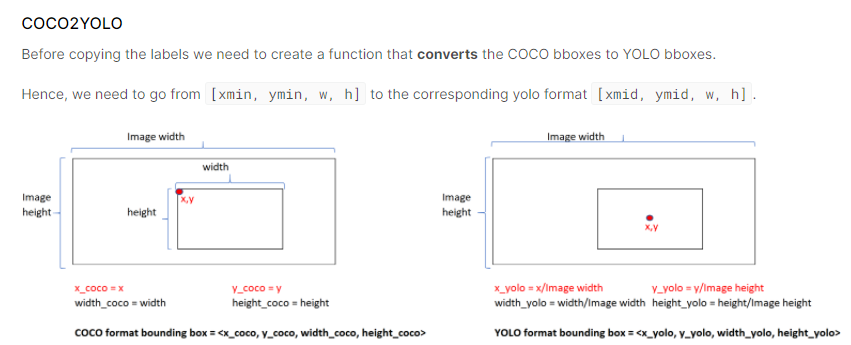

In [ ]:
def coco2yolo(image_height, image_width, bboxes):
    """
    Converts a coco annotation format [xmin, ymin, w, h] to 
    the corresponding yolo format [xmid, ymid, w, h]
    
    image_height: height of the original image
    image_width: width of the original image
    bboxes: coco boxes to be converted
    return;
    """
    
    bboxes = np.array(bboxes).astype(float)
    
    # Normalize xmin, w
    bboxes[:, [0, 2]]= bboxes[:, [0, 2]] / image_width
    # Normalize ymin, h
    bboxes[:, [1, 3]]= bboxes[:, [1, 3]] / image_height
    
    # Converstion (xmin, ymin) => (xmid, ymid)
    bboxes[:, [0, 1]] = bboxes[:, [0, 1]] + bboxes[:, [2, 3]] / 2
    
    # Clip values (between 0 and 1)
    bboxes = np.clip(bboxes, a_min = 0, a_max = 1)
    
    return bboxes

In [ ]:
# --- Example ---
bbox_example = [[559, 213, 50, 32], [679, 223, 10, 100]]

print("From COCO : ", bbox_example)
print("to YOLO : ", coco2yolo(image_height = 720, 
                    image_width = 1280, 
                    bboxes = bbox_example))

In [ ]:
train.sample(3, random_state=24)

In [ ]:
# Populate the ../labels folder
yolo_bboxes = []
count = 0
for k in tqdm(range(len(train))):
    
    row_data = train.iloc[k, :]
    height = row_data["height"]
    width = row_data["width"]
    coco_bbox = eval(row_data["coco_bbox"])
    len_bbox = row_data["no_annotations"]
    labels = row_data["labels"]
    video_id = 'video'
    
    if(count <= 3935):
        
        path_labels = f"./labels/train/{video_id}_{labels}"
        
        # Create file and write in it
        with open(path_labels, 'w') as file:
            # In case there is an image with no present annotation
            if len_bbox == 0: 
                file.write("")
                continue

            # Convert coco format to yolo format
            yolo_bbox = coco2yolo(height, width, coco_bbox)
            yolo_bboxes.append(yolo_bbox)

            # Write annotations in file
            for i in range(len_bbox):
                annot = ["0"] + yolo_bbox[i].astype(str).tolist() + ([""] if i+1 == len_bbox else ["\n"])
                annot = " ".join(annot).strip()
                file.write(annot)
    else:
        path_labels = f"./labels/val/{video_id}_{labels}"

        
        # Create file and write in it
        with open(path_labels, 'w') as file:
            # In case there is an image with no present annotation
            if len_bbox == 0: 
                file.write("")
                continue

            # Convert coco format to yolo format
            yolo_bbox = coco2yolo(height, width, coco_bbox)
            yolo_bboxes.append(yolo_bbox)

            # Write annotations in file
            for i in range(len_bbox):
                annot = ["0"] + yolo_bbox[i].astype(str).tolist() + ([""] if i+1 == len_bbox else ["\n"])
                annot = " ".join(annot).strip()
                file.write(annot)
    count += 1
# Add yolo boxes to dataframe
train["yolo_bbox"] = yolo_bboxes
train.sample(3, random_state=24)

In [ ]:
# Use Video 0 and 2 for training and 1 for validation
train_data = train[train["video_id"].isin([0, 2])]
test_data = train[train["video_id"].isin([1])]

# Get path to images & labels
train_images = list(train_data["images"])
train_labels = list(train_data["labels"])

test_images = list(test_data["images"])
test_labels = list(test_data["labels"])

print("Train Length:", len(train_data), "\n" + "Test Length:", len(test_data))

In [ ]:
%cd /kaggle/working/
!rm cots.yaml
!dir

In [ ]:
# Create configuration
config = {'train': '../images/train',
          'val': '../images/val',
          'nc': 1,
          'names': ['cots']}

with open("cots.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style = False)   

print("Finish")

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone
# !cd yolov5
# !pip install -r requirements.txt  # install
# %cd yolov5
# !dir

In [ ]:
# ---> YOLOv5 install <---
# %cd /kaggle/working   

%cd /kaggle/working
!mkdir yolov5

%cd /kaggle/input
!cp -r /kaggle/input/yolov5 /kaggle/working     
%cd /kaggle/working/yolov5 

from yolov5 import utils
display = utils.notebook_init()

In [ ]:
# --- PARAMETERS ---
# These are just small samples, so the notebook runs faster
SIZE = 512
BATCH_SIZE = 4
EPOCHS = 3
MODEL = "yolov5s"
WORKERS = 1
PROJECT = "GreatBarrierReef"
RUN_NAME = f"{MODEL}_size{SIZE}_epochs{EPOCHS}_batch{BATCH_SIZE}_simple"
# ------------------

In [ ]:
%cd /kaggle/working/yolov5
!ls /root/.config/Ultralytics/

In [ ]:
!cp -r /kaggle/input/arialttf/Arial.ttf /root/.config/Ultralytics/Arial.ttf
!cp -r /kaggle/input/yolov5spt/yolov5s.pt /kaggle/working/yolov5/yolov5s.pt

In [ ]:
# Training
!wandb off
!python train.py --img {SIZE}\
                 --batch {BATCH_SIZE}\
                 --epochs {EPOCHS}\
                 --data ../cots.yaml\
                 --weights {MODEL}.pt\
                 --workers {WORKERS}\
                 --project {PROJECT}\
                 --name {RUN_NAME}\
                 --exist-ok

In [ ]:
%cd GreatBarrierReef/yolov5s_size512_epochs3_batch4_simple

In [ ]:
plt.figure(figsize = (20, 20))
img_sample = cv2.imread("results.png")
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
plt.imshow(img_sample)
plt.axis("off")

In [ ]:
f = open("results.csv", "r")
print(f.read())

In [ ]:
import greatbarrierreef
env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (pixel_array, sample_prediction_df) in iter_test:
    sample_prediction_df['annotations'] = '0.14372 0.22323 0.34846 0.18184 0.26967'  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

In [ ]:
!ls ../../../2021-greatbarrierreef-prep-data/

In [ ]:
!cp results.csv ../../../2021-greatbarrierreef-prep-data/submission.csv